# Import

In [1]:
from pprint import pprint

from IPython.display import display
from hamilton import driver
import pandas as pd

import __init__ as nixtla_mlforecast

# Build Driver

Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


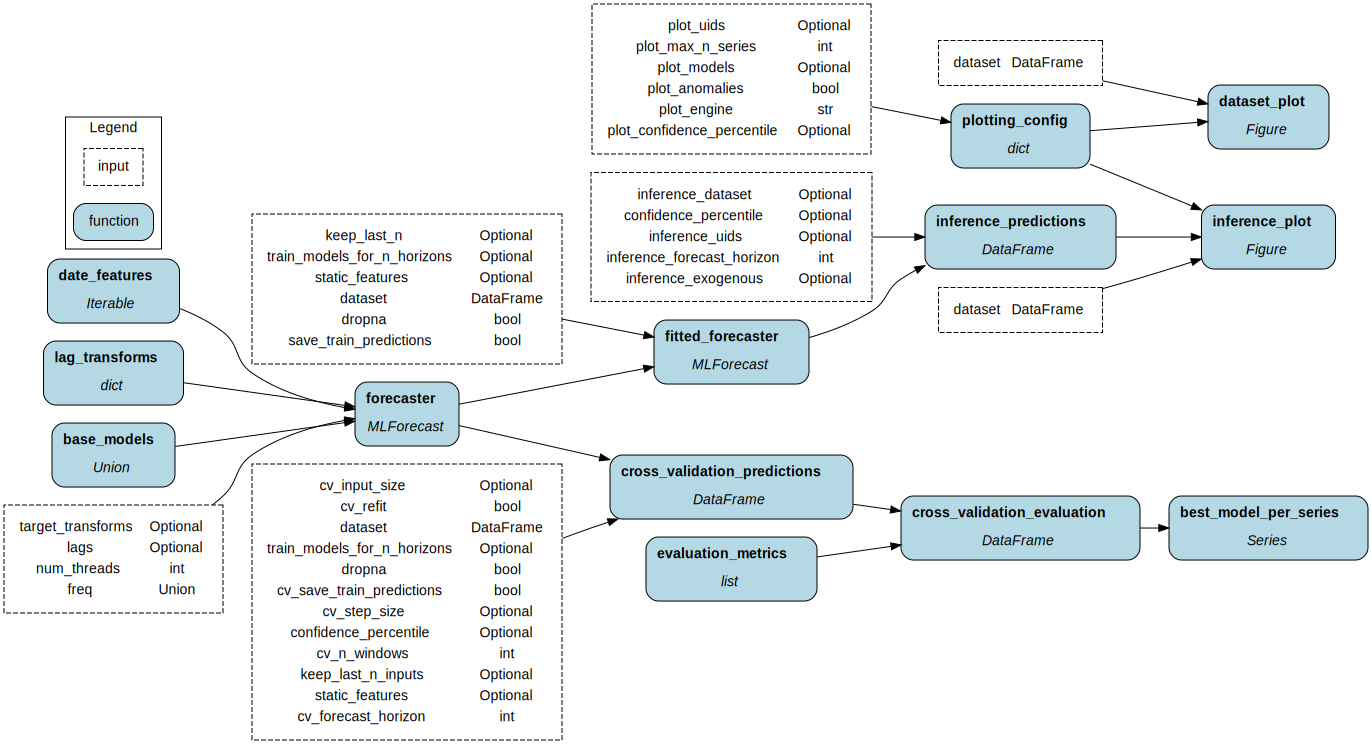

In [2]:
dr = (
    driver.Builder()
    .with_modules(nixtla_mlforecast)
    .build()
)

# create the DAG image
display(dr.display_all_functions(None))

# Load dataset

In [3]:
def download_m4_dataset() -> pd.DataFrame:
    """Download Nixtla's version of the M4 hourly dataset. ref: https://paperswithcode.com/dataset/m4"""
    return pd.read_parquet("https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet")


def filter_dataset(raw_dataset: pd.DataFrame, n_ids: int = 4, n_days: int = 7) -> pd.DataFrame:
    """Filter the dataset to `n_ids` series for a period of `n_days`"""
    selection = raw_dataset.unique_id.unique()[:n_ids]
    df = raw_dataset.loc[raw_dataset.unique_id.isin(selection)]
    df = df.groupby("unique_id").tail(n_days * 24)  # the dataset contains 24 points per day
    return df


raw_df = download_m4_dataset()
df = filter_dataset(raw_df)

In [4]:
final_vars = [v for v in dr.graph.get_nodes() if v._tags.get("module") == "__init__"]

inputs = dict(
    dataset=df,
    freq=1,
    lags=list(range(1, 25, 1)),
)

overrides = dict()

results = dr.execute(
    final_vars=final_vars,
    inputs=inputs,
    overrides=overrides
)

pprint(list(results.keys()), width=1)

['base_models',
 'best_model_per_series',
 'cross_validation_evaluation',
 'cross_validation_predictions',
 'dataset_plot',
 'date_features',
 'evaluation_metrics',
 'fitted_forecaster',
 'forecaster',
 'inference_plot',
 'inference_predictions',
 'lag_transforms',
 'plotting_config']


In [5]:
results["cross_validation_evaluation"]

,index,cutoff,RandomForestRegressor,HistGradientBoostingRegressor
unique_id,,,,
H1,4.290707e+05,2.328300e+04,1184.566658,1732.309856
H10,1.884320e+05,7.953904e+04,53.775208,58.240593
H100,1.014592e+06,1.518791e+05,31838.944483,33989.090776
H101,4.936327e+06,2.356917e+06,7113.219475,18938.530196


In [6]:
results["best_model_per_series"]

unique_id
H1      RandomForestRegressor
H10     RandomForestRegressor
H100    RandomForestRegressor
H101    RandomForestRegressor
dtype: object

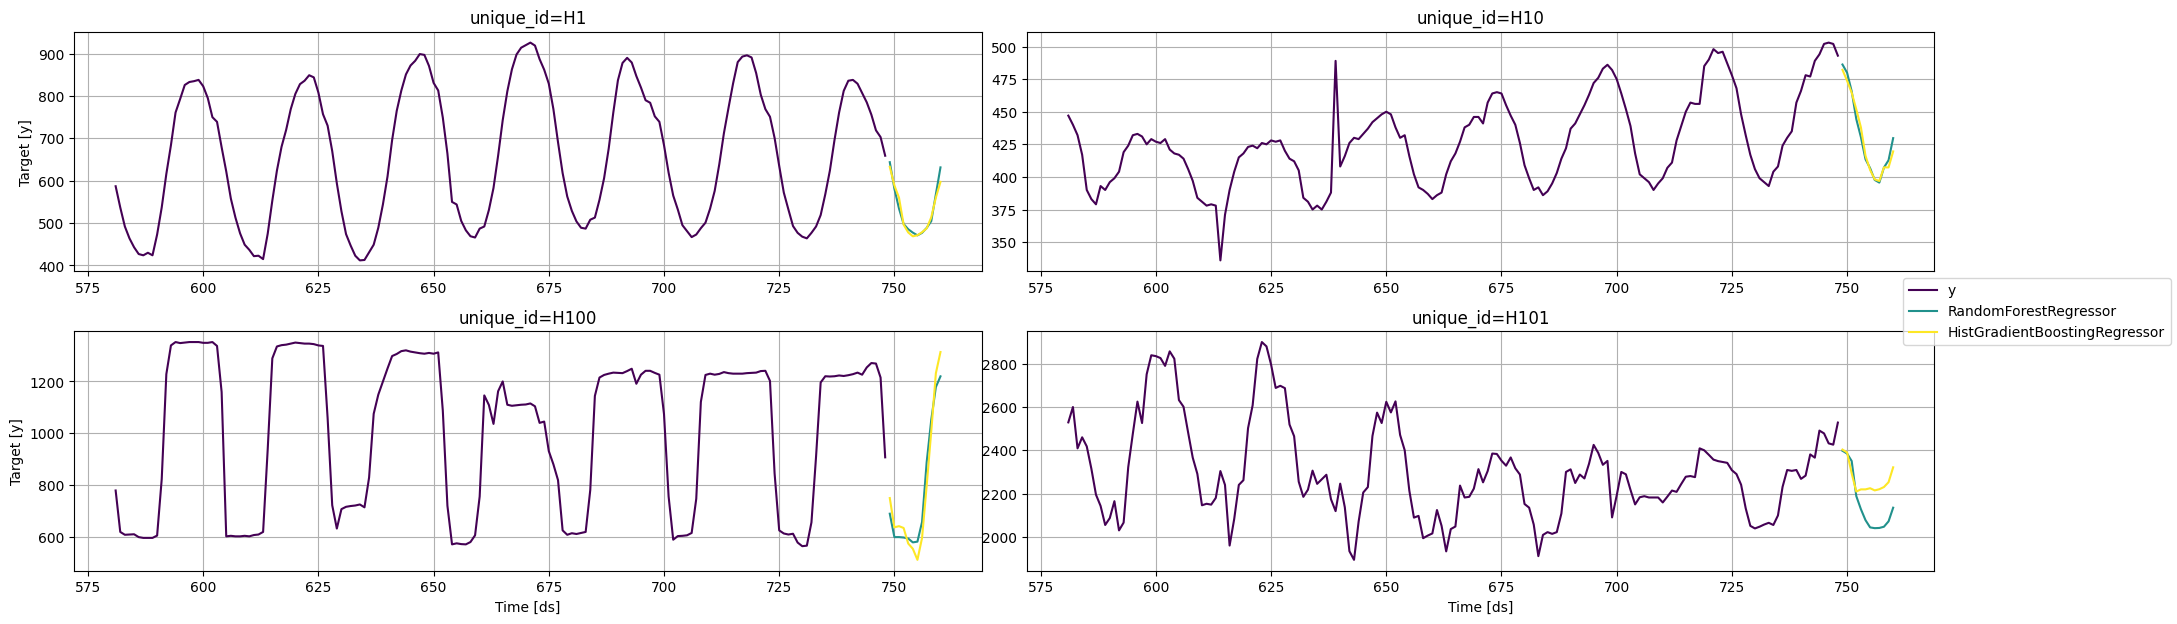

In [7]:
results["inference_plot"]